Welcome!  If you are new to Google Colab/Jupyter notebooks, you might take a look at [this notebook](https://colab.research.google.com/notebooks/basic_features_overview.ipynb) first.

**I recommend you run the first code cell of this notebook immediately, to start provisioning drake on the cloud machine, then you can leave this window open as you [read the textbook](http://underactuated.csail.mit.edu/multibody.html).**

# Notebook Setup

The following cell will:
- on Colab (only), install Drake to `/opt/drake`, install Drake's prerequisites via `apt`, and add pydrake to `sys.path`.  This will take approximately two minutes on the first time it runs (to provision the machine), but should only need to reinstall once every 12 hours.  If you navigate between notebooks using Colab's "File->Open" menu, then you can avoid provisioning a separate machine for each notebook.
- import packages used throughout the notebook.

You will need to rerun this cell if you restart the kernel, but it should be fast (even on Colab) because the machine will already have drake installed.

In [ ]:
import importlib
import sys
from urllib.request import urlretrieve

# Install drake (and underactuated).
if 'google.colab' in sys.modules and importlib.util.find_spec('underactuated') is None:
    urlretrieve(f"http://underactuated.csail.mit.edu/scripts/setup/setup_underactuated_colab.py",
                "setup_underactuated_colab.py")
    from setup_underactuated_colab import setup_underactuated
    setup_underactuated(underactuated_sha='560c2adace05eb20ebd78377582015d5b2d3859a', drake_version='0.27.0', drake_build='release')

# Understanding the "relaxed complementarity-free" approximation

Here is a simple interactive plot to understand the difference between the time-stepping LCP solution and the algorithm in MuJoCo.


<IPython.core.display.Javascript object>


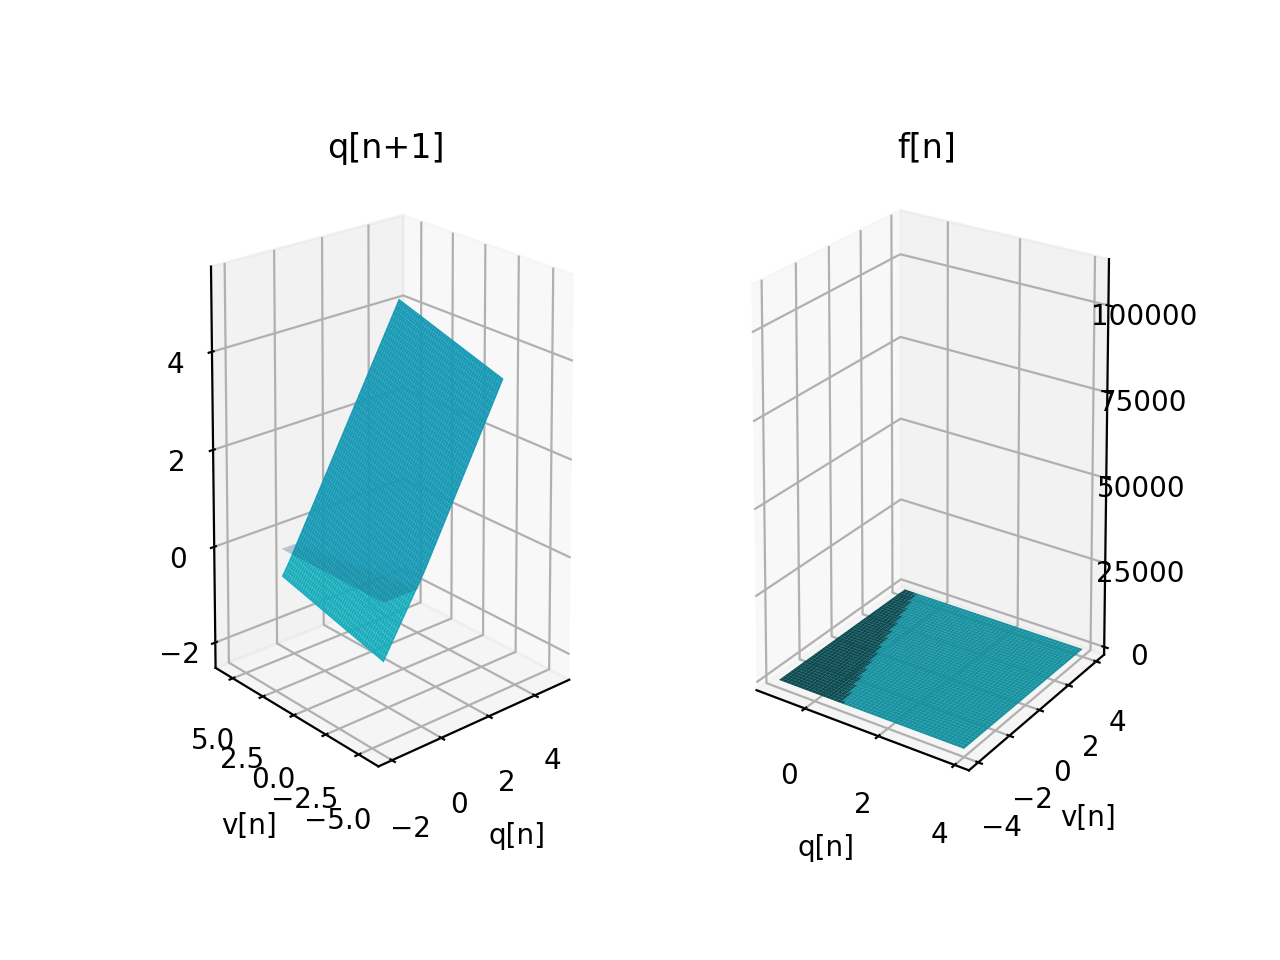

interactive(children=(FloatSlider(value=0.1, description='b', max=1.0), FloatSlider(value=0.001, description='…

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact

from underactuated.jupyter import SetupMatplotlibBackend
plt_is_interactive = SetupMatplotlibBackend()

q = np.linspace(-1,4,51)
v = np.linspace(-4,4,51)
f = np.zeros((len(q), len(v)))
qn = np.zeros((len(q), len(v)))

[Q, V] = np.meshgrid(q, v)
F = 0*Q
Qn = 0*Q

h = 0.1
m = 1

# First plot the LCP solution:
for i in range(len(q)):
  for j in range(len(v)):
    if (q[i] + h*v[j] >= 0):
      Qn[j, i] = q[i] + h*v[j]
      F[j,i] = 0
    else:
      Qn[j, i] = 0
      F[j, i] = -m*(q[i] + h*v[j])/h**2

fig = plt.figure()
ax1, ax2 = fig.subplots(1, 2, subplot_kw=dict(projection='3d'))
ax1.plot_surface(Q, V, Qn, rstride=1, cstride=1, alpha=0.3)
ax2.plot_surface(Q, V, F, rstride=1, cstride=1, alpha=0.3)
ax1.set_xlabel("q[n]")
ax1.set_ylabel("v[n]")
ax1.set_title("q[n+1]")
ax2.set_xlabel("q[n]")
ax2.set_ylabel("v[n]")
ax2.set_title("f[n]")

# Now the "relaxed complementarity-free" version
def complementarityFree(b=0.1, e=1e-4, k=.1):
    for i in range(len(q)):
      for j in range(len(v)):
        vminus = v[j] - h*b*v[j]/(m+b)
        vstar = v[j] - 2*h*(1+e)*v[j]/k - h*(1+e)*q[i]/k**2
        f = -(vminus - vstar)*(m+b)/(1+e)
        F[j, i] = np.maximum(f, 0)
        vn = v[j] + h*(-b*v[j] + F[j,i])/(m+b)
        Qn[j,i] = q[i] + h*vn

complementarityFree()
Qn_surf = ax1.plot_surface(Q, V, Qn, rstride=1, cstride=1)
F_surf = ax2.plot_surface(Q, V, F, rstride=1, cstride=1)
        
def update(b=0.1, e=1e-3, k=.1):
    global Qn_surf
    global F_surf
    Qn_surf.remove()
    F_surf.remove()
    complementarityFree(b, e, k)
    Qn_surf = ax1.plot_surface(Q, V, Qn, rstride=1, cstride=1)
    F_surf = ax2.plot_surface(Q, V, F, rstride=1, cstride=1)
    fig.canvas.draw()

if plt_is_interactive:
  interact(update, b=(0, 1, 0.1), e=(0, .1, 0.01), k=(0.001, .1, 0.01))
  


<IPython.core.display.Javascript object>


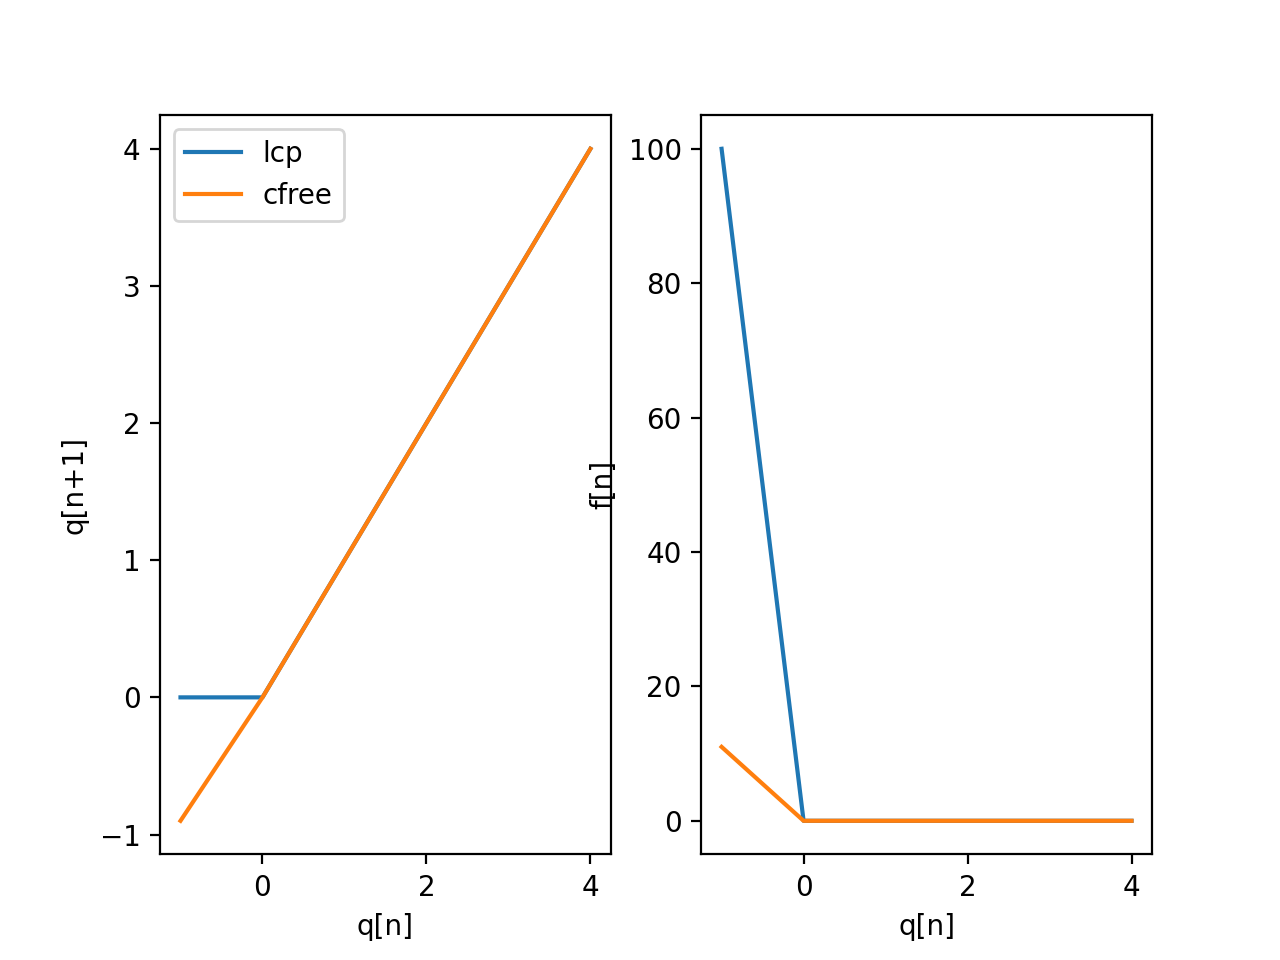

interactive(children=(FloatSlider(value=0.0, description='v', max=4.0, min=-4.0), FloatSlider(value=0.1, descr…

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact

from underactuated.jupyter import SetupMatplotlibBackend
plt_is_interactive = SetupMatplotlibBackend()

q = np.linspace(-1,4,51)

h = 0.1
m = 1

def lcp(q, v):
    if (q + h*v >= 0):
        qn = q + h*v
        f = 0
    else:
        qn = 0
        f = -m*(q + h*v)/h**2
    return qn, f

def Lcp(q, v):
    qn = 0*q
    f = 0*q
    for i in range(len(q)):
        qn[i], f[i] = lcp(q[i], v)
    return qn, f

def complementarityFree(q, v, b, e, k):
    vminus = v - h*b*v/(m+b)
    vstar = v - 2*h*(1+e)*v/k - h*(1+e)*q/k**2
    f = -(vminus - vstar)*(m+b)/(1+e)
    f = np.maximum(f, 0)
    vn = v + h*(-b*v + f)/(m+b)
    qn = q + h*vn
    return qn, f

def ComplementarityFree(q, v, b=0.1, e=1e-4, k=.1):
    qn = 0*q
    f = 0*q
    for i in range(len(q)):
        qn[i], f[i] = complementarityFree(q[i], v, b, e, k)
    return qn, f

fig = plt.figure()
ax1, ax2 = fig.subplots(1, 2)
qn, f = Lcp(q, 0)
lcp_qn, = ax1.plot(q, qn, label="lcp")
lcp_f, = ax2.plot(q, f, label="lcp")
ax1.set_xlabel("q[n]")
ax1.set_ylabel("q[n+1]")
ax2.set_xlabel("q[n]")
ax2.set_ylabel("f[n]")

qn, f = ComplementarityFree(q, 0)
cfree_qn, = ax1.plot(q, qn, label="cfree")
cfree_f, = ax2.plot(q, f, label="cfree")
ax1.legend()
        
def update(v=0, b=0.1, e=1e-3, k=.1):
    qn, f = Lcp(q, v)
    lcp_qn.set_ydata(qn)
    lcp_f.set_ydata(f)
    qn, f = ComplementarityFree(q, v, b, e, k)
    cfree_qn.set_ydata(qn)
    cfree_f.set_ydata(f)
    fig.canvas.draw()

if plt_is_interactive:
  interact(update, v=(-4, 4, 0.1), b=(0, 1, 0.1), e=(0, 1, 0.1), k=(0.001, .1, 0.01))
  
